In [1]:
import csv
import json
from collections import defaultdict
import matplotlib.pyplot as plt
import string
import nltk
#nltk.download('stopwords')
from nltk.corpus import stopwords
from operator import itemgetter

In [2]:
def load_data():
    data = []
    label = ['image_id','unixtime','rawtime','title','total_votes','reddit_id','number_of_upvotes',\
    'subreddit','number_of_downvotes','localtime','score','number_of_comments','username',\
    'undefined1','undefined2', 'undefined3']

    with open('submissions.csv') as csvfile:
        csvReader = csv.reader(csvfile)
        for row in csvReader:
            if row[0] == '#image_id':
                continue
            d = {}
            for i,elem in enumerate(row):
                if label[i]=='total_votes' or label[i]=='number_of_upvotes' or label[i]=='number_of_downvotes' or label[i]=='score' or label[i]=='number_of_comments':
                    d[label[i]] = int(elem)
                else:
                    d[label[i]] = elem
                    #judge if element it is empty
            data.append(d)
    return data

In [3]:
data = load_data()
comments_sorted_data = sorted(data, key=itemgetter('number_of_comments'), reverse=True)
votes_sorted_data = sorted(data, key=itemgetter('total_votes'), reverse=True)

In [4]:
def title():
    wordCount = defaultdict(int)
    punctuation = set(string.punctuation)

    # word count in top 25000 titles with most comment numbers
    for d in comments_sorted_data[0:25000]:
        r = ''.join([c for c in d['title'].lower() if not c in punctuation])
        for w in r.split():
            wordCount[w] += 1

    # remove English stopwords
    for w in stopwords.words("english"):
        if w in wordCount:
            wordCount.pop(w)

    #print(len(wordCount))
    counts = [(wordCount[w], w) for w in wordCount]
    counts.sort()
    counts.reverse()

    # take top 1000 words to be targets
    words = [x[1] for x in counts[:1000]]
    wordId = dict(zip(words, range(len(words))))
    wordSet = set(words)

    title_comment_list = []
    for d in data:
        title_comment_num = 0
        for i,w in enumerate(words):
            if w in d['title']:
                title_comment_num = title_comment_num + (1000-i)
        title_comment_list.append(title_comment_num)

    return title_comment_list

In [5]:
#subreddit feature
def get_popular_subreddit():
    sub_post_num = defaultdict(int)
    sub_post_sorted = {}
    for d in data:
        sub = d.get('subreddit')
        sub_post_num[sub] += 1
    for key, value in sorted(sub_post_num.iteritems(), key=lambda (k,v): (v,k),reverse = True):
        sub_post_sorted[key] = value
        #sub_post_sorted.append((key,value))
        #print "%s: %s" % (key, value)
    return sub_post_sorted

sub_post_sorted = get_popular_subreddit()

In [6]:
def popular_subreddit():
    subreddit_list = []
    for d in data:
        sub = d.get('subreddit')
        subreddit_list.append(sub_post_sorted[sub])
    return subreddit_list

subreddit_list = popular_subreddit()

In [7]:
import re
def get_time_feature(d):
    # Create dummy variables based on exploratory analysis of this dataset and previous plots
    time_feature = []  #night(22-1),sleep time(2-7),morning(8-11),afternoon(12-17),[evening(18-21) is omitted]
                       #UTC+8,UTC+7,[UTC+0 is omitted]
    
    catchTime = re.compile("(.*)T(\d{2}):(\d{2}).*((-|\+)\d{2})")
    
    
    t = d['rawtime']
    m = catchTime.search(t)
    if m:
        d['hour'] = int(m.group(2))
        d['minute'] = int(m.group(3))
        if d['minute'] >= 30:
            d['time'] = (d['hour'] +1*0)%24
        else:
            d['time'] = d['hour']

        d['timezone'] = int(m.group(4))
        d['UTCtime'] = (d['time'] + d['timezone'])%24
            
    if d['UTCtime'] >= 22 or d['UTCtime'] <= 1:
        time_feature.append(1)
    else:
        time_feature.append(0)
        
    if d['UTCtime'] >= 2 and d['UTCtime'] <= 7:
        time_feature.append(1)
    else:
        time_feature.append(0)
        
    if d['UTCtime'] >= 8 and d['UTCtime'] <= 11:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['UTCtime'] >= 12 and d['UTCtime'] <= 17:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['timezone'] == -8:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    if d['timezone'] == -7:
        time_feature.append(1)
    else:
        time_feature.append(0)
    
    return time_feature

In [8]:
import datetime
def get_date_feature(d):
    date_feature = [0]*17 #month(1-11),weekday(Monday-Saturday)
    t = d['unixtime']
    this_day = datetime.datetime.utcfromtimestamp(int(t))
    if this_day.month != 12 and this_day.weekday() != 6:
        date_feature[this_day.month-1] = 1
        date_feature[this_day.weekday()+11] = 1
    return date_feature


In [9]:
raw_time_list = []
date_list = []
for d in data:
    raw_time_list.append(get_time_feature(d))
    date_list.append(get_date_feature(d))

In [10]:
# submission time feature
def submission():
    ID = '-1'
    submission_list = []

    # original data is sorted in image_ID, count submission times before current submission
    for d in data:
        if d['image_id'] == ID:
            count = count + 1
            d['submission_time'] = count
        else:
            count = 0
            ID = d['image_id']
            d['submission_time'] = count

    for d in data:
        submission_list.append(d['submission_time'])

    return submission_list

In [11]:
# username feature
def username():
    with open('all_user_profile.json', 'r') as f:
        all_user_profile = json.load(f)
    #post_list = []
    #user_votes_list = []
    #user_votes_dict = {}
    user_comment_list = []
    user_comment_dict = {}
    for user in all_user_profile:
        #post_list.append(user.get('num_of_post'))
        #user_votes_dict[user.get('username')] = user.get('avg_votes')
        user_comment_dict[user.get('username')] = user.get('avg_comments')

    for d in data:
        if d['username']=='':
            user_comment_list.append(d['number_of_comments'])
        elif d['username'] in user_comment_dict:
            user_comment_list.append(user_comment_dict[d['username']])
        #if d['username'] in user_votes_dict:
            #user_votes_list.append(user_votes_dict[d['username']])

    return user_comment_list

In [12]:
#subreddit feature
def subreddit():
    with open('all_subreddit_profile.json', 'r') as f:
        all_subreddit_profile = json.load(f)
    #post_list = []
    sub_comment_list = []
    sub_comment_dict = {}
    sub_votes_list = []
    sub_votes_dict = {}
    for sub in all_subreddit_profile:
        # post_list.append(sub.get('num_of_post'))
        #sub_votes_dict[sub.get('subreddit')] = sub.get('avg_votes')
        sub_comment_dict[sub.get('subreddit')] = sub.get('avg_comments')

    for d in data:
        if d['subreddit']=='':
            sub_comment_list.append(d['number_of_comments'])
        elif d['subreddit'] in sub_comment_dict:
            sub_comment_list.append(sub_comment_dict[d['subreddit']])
        #if d['subreddit'] in sub_votes_dict:
            #sub_votes_list.append(sub_votes_dict[d['subreddit']])

    return sub_comment_list

In [13]:
with open('kmean_d.json', 'r') as f:
        Kmeans_title = json.load(f)

In [14]:
with open('title_len_list.json', 'r') as f:
        title_len_list = json.load(f)

In [18]:
# with open('LSA_m.json', 'r') as f:
#         LSA_m = json.load(f)
#Tuoying's part is missing :(

In [19]:
submission_list = submission()

comment_feature_list = []
comment_label_list = []
for i in range(len(data)):
    large = 0
#Kmeans_title[i],
#subreddit_list[i],
    tmp_list = [submission_list[i],title_len_list[i],raw_time_list[i][0],raw_time_list[i][1],raw_time_list[i][2],raw_time_list[i][3],raw_time_list[i][4],raw_time_list[i][5]]
# 100 d LSA feature
    #     for k in LSA_m[i]:
#         tmp_list.append(k) 
#17 d date feature
#     for d in date_list[i]:
#          tmp_list.append(d)
    tmp_list.extend(date_list[i])
    comment_feature_list.append(tmp_list)
    
    if data[i]['number_of_comments']*0.2 + data[i]['total_votes']*0.8  > 36: large = 1 #votes and comment label 
    #if data[i]['number_of_comments'] > 3: large = 1 #comment label 
    #if data[i]['total_votes'] > 45: large = 1 #votes label 
    comment_label_list.append(large)

print "feature[title_keyword,submission_time,username,subreddit]:",len(comment_feature_list[0])
print "label[total_votes]:",comment_label_list[0]

feature[title_keyword,submission_time,username,subreddit]: 25
label[total_votes]: 1


In [20]:
comment_feature_list[564]

[11, 5, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [21]:
comment_label_list[19]

0

In [22]:
comment_feature_list[0]

[0, 4, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [23]:
import os
import time
from sklearn import metrics
import numpy as np
import pickle

import sys

In [24]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 0.19.1.


In [25]:
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

//anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [26]:
X_train, X_test, y_train, y_test = train_test_split(comment_feature_list, comment_label_list, random_state=4)

In [27]:
X_train[0:10]

[[5, 8, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [16, 7, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0],
 [1, 6, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
 [3, 8, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [0, 9, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
 [12, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1],
 [4, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
 [4, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [3, 5, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0],
 [8, 8, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]]

In [28]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
min_max_scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [29]:
len(X_train)

99230

In [30]:
len(X_test)

33077

In [31]:
X_train[0:10]

array([[-0.25810155,  0.31366411, -0.45460294, -0.63410438, -0.44275513,
         1.72046876, -0.18079946,  0.71826926, -0.21337249, -0.16718038,
         5.21366805, -0.21205259, -0.21568545, -0.23782342, -0.30874974,
        -0.33838666, -0.4420712 , -0.40756406, -0.28530026, -0.40658849,
        -0.40652117, -0.40581404, -0.40927731,  2.60074379, -0.37074249],
       [ 0.56022825,  0.09901414,  2.19972183, -0.63410438, -0.44275513,
        -0.58123694, -0.18079946,  0.71826926, -0.21337249, -0.16718038,
        -0.19180354, -0.21205259, -0.21568545, -0.23782342, -0.30874974,
        -0.33838666,  2.26207904, -0.40756406, -0.28530026, -0.40658849,
        -0.40652117, -0.40581404,  2.44333118, -0.38450539, -0.37074249],
       [-0.55567602, -0.11563583, -0.45460294,  1.57702742, -0.44275513,
        -0.58123694, -0.18079946,  0.71826926, -0.21337249, -0.16718038,
         5.21366805, -0.21205259, -0.21568545, -0.23782342, -0.30874974,
        -0.33838666, -0.4420712 , -0.40756406, -0

## KNN Classifier

### TEST SET

In [29]:
# check classification accuracy of KNN with K=5
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
predict = knn.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

precision: 60.16%, recall: 59.57%
accuracy: 60.33%


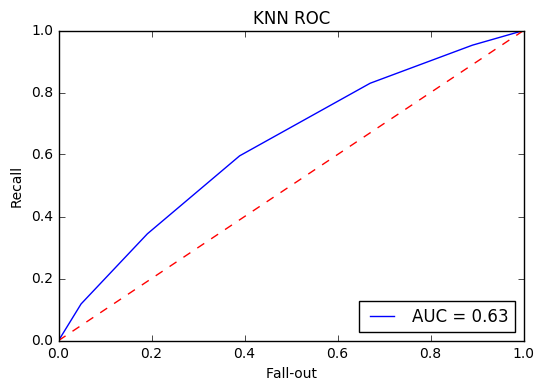

In [30]:
from sklearn.metrics import roc_curve, auc  
predictions = knn.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('KNN ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out')
plt.savefig('KNN ROC.png',dpi=600)
plt.show() 

### Validation

In [32]:
from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics.scorer import make_scorer
from sklearn.metrics import recall_score

In [32]:
scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}

knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
knn = KNeighborsClassifier(n_neighbors=5)
all_scores = cross_validate(knn, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.60 (+/- 0.01)
Recall: 0.60 (+/- 0.01)
Precision: 0.60 (+/- 0.01)


In [32]:
### Hyperparameter (SKIP)

In [33]:
# search for an optimal value of K for KNN
k_range = list(range(1, 31))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    k_scores.append(scores.mean())
print(k_scores)

[0.55954857070213671, 0.56027401250258058, 0.58705004502641722, 0.58876335847848149, 0.60179368501435315, 0.60085655983872344, 0.61232475820822496, 0.61145813863957188, 0.61825046478786683, 0.61888534632800873, 0.62349097801826958, 0.62215047270472001, 0.6271390002964139, 0.62734049334669417, 0.63127087826652839, 0.631432009125792, 0.63331649346113861, 0.6323288411714636, 0.63489866611971491, 0.63454590653920495, 0.63682353194055785, 0.63653120544977659, 0.63809332446907208, 0.63702508897041643, 0.63958474187788161, 0.63859712512930067, 0.64043123468367158, 0.6395141783858288, 0.64057233831384452, 0.63969559747847893]


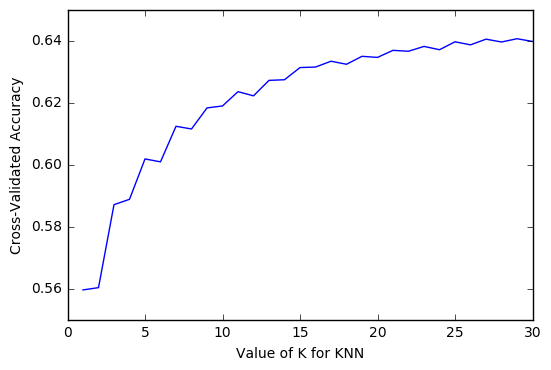

In [34]:
import matplotlib.pyplot as plt
%matplotlib inline
# plot the value of K for KNN (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(k_range, k_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated Accuracy')
plt.show()

In [35]:
# The optimal value of K is 15
knn = KNeighborsClassifier(n_neighbors=15)
knn_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
print(knn_scores.mean())

0.631270878267


## Multinomial Naive Bayes Classifier

###TEST SET

In [36]:
from sklearn.naive_bayes import GaussianNB
NB = GaussianNB()
NB.fit(X_train, y_train)
predict = NB.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

precision: 60.19%, recall: 76.79%
accuracy: 63.24%


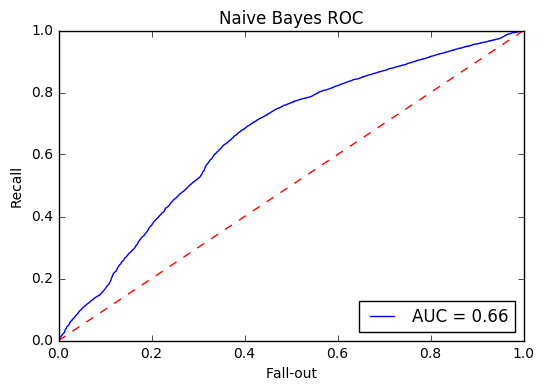

In [37]:
from sklearn.metrics import roc_curve, auc  
predictions = NB.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Naive Bayes ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out')  
plt.savefig('Naive Bayes ROC.png',dpi=600)
plt.show()  

###Validation

In [38]:
# Multinomial Naive Bayes Classifier
NB = GaussianNB()
NB_scores = cross_val_score(NB, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (NB_scores.mean(), NB_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(NB, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.63 (+/- 0.01)
Recall: 0.63 (+/- 0.01)
Precision: 0.64 (+/- 0.01)


## Logistic Regression Classifier

### Validation

In [33]:
# Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression(penalty='l2', class_weight = 'balanced') # balanced：让类库自己计算类型权重
LR_scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (LR_scores.mean(), LR_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(LR, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.66 (+/- 0.01)
Recall: 0.66 (+/- 0.01)
Precision: 0.66 (+/- 0.01)


### Hyperparameter(SKIP)

In [40]:
# search for an optimal value of C for LR
C_range = [0.01,0.1,1.0,10.0,100.0,1000.0]
C_scores = []
for c in C_range:
    LR = LogisticRegression(C = c, penalty='l2', class_weight = 'balanced')
    scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
    C_scores.append(scores.mean())
print(C_scores)# The optimal value of C is 0.01
LR = LogisticRegression(C = 0.01, penalty='l2', class_weight = 'balanced') # balanced：让类库自己计算类型权重
LR_scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
print(LR_scores.mean())

[0.64058240575820902, 0.64054209638306936, 0.64053201980104602, 0.64053201980104602, 0.64053201980104602, 0.64053201980104602]
0.640582405758


In [41]:
# The optimal value of C is 0.01
LR = LogisticRegression(C = 0.01, penalty='l2', class_weight = 'balanced') # balanced：让类库自己计算类型权重
LR_scores = cross_val_score(LR, X_train, y_train, cv=10, scoring='accuracy')
print(LR_scores.mean())

0.640582405758


## test set

In [34]:
LR.fit(X_train,y_train)
theta = LR.coef_
predict = LR.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )
print("Theta",theta)

precision: 64.67%, recall: 69.77%
accuracy: 66.05%
('Theta', array([[-0.37144436, -0.02347957,  0.04094704,  0.00194088,  0.02391902,
         0.01820491, -0.01376737,  0.38655975,  0.07524588,  0.12291697,
         0.14388276,  0.10014861,  0.08800185,  0.05255167, -0.07999241,
        -0.12938848, -0.16938931, -0.14619977, -0.01037853, -0.03111783,
        -0.05102258, -0.03895545, -0.0582152 , -0.03594115,  0.02645251]]))


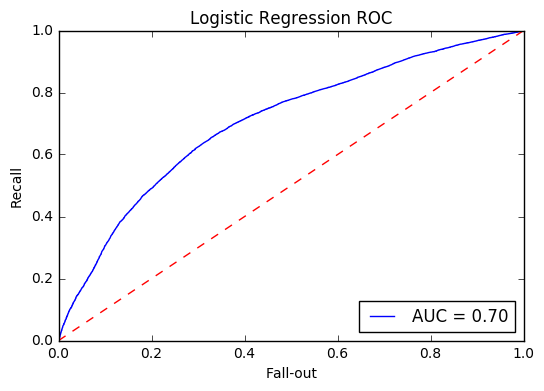

In [35]:
from sklearn.metrics import roc_curve, auc  
predictions = LR.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Logistic Regression ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out') 
plt.savefig('Logistic Regression ROC.png',dpi=600)
plt.show()  

## Random Forest Classifier
特征很少，用随机森林应该效果不明显

###Validation

In [44]:
from sklearn.ensemble import RandomForestClassifier
RF = RandomForestClassifier(n_estimators=100,class_weight = 'balanced')
RF_scores = cross_val_score(RF, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (RF_scores.mean(), RF_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(RF, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.63 (+/- 0.01)
Recall: 0.63 (+/- 0.01)
Precision: 0.63 (+/- 0.01)


In [45]:
### TEST SET

In [46]:
RF.fit(X_train,y_train)
predict = RF.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

precision: 61.54%, recall: 69.67%
accuracy: 63.31%


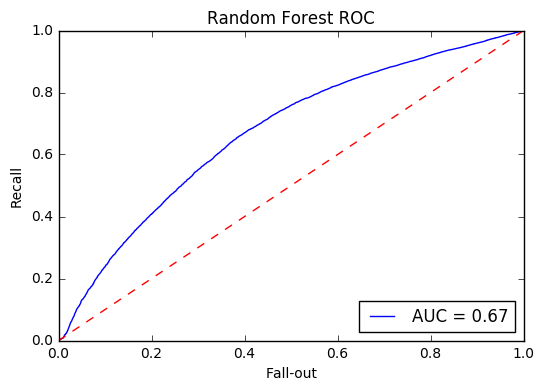

In [47]:
from sklearn.metrics import roc_curve, auc  
predictions = RF.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Random Forest ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out')  
plt.savefig('Random Forest ROC.png',dpi=600)
plt.show()  

## Decision Tree Classifier

In [36]:
### Validation

In [37]:
from sklearn import tree
# max_depth = 4, 限制树的最大深度4,其实特征少的时候不用限制这个深度，但不知道为什么这里限制了之后准确率提高
DT = tree.DecisionTreeClassifier(class_weight = 'balanced',max_depth = 4) 
DT_scores = cross_val_score(DT, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (DT_scores.mean(), DT_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(DT, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.66 (+/- 0.01)
Recall: 0.66 (+/- 0.01)
Precision: 0.66 (+/- 0.01)


In [38]:
### TEST SET

In [39]:
DT.fit(X_train,y_train)
predict = DT.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

precision: 66.87%, recall: 62.95%
accuracy: 66.11%


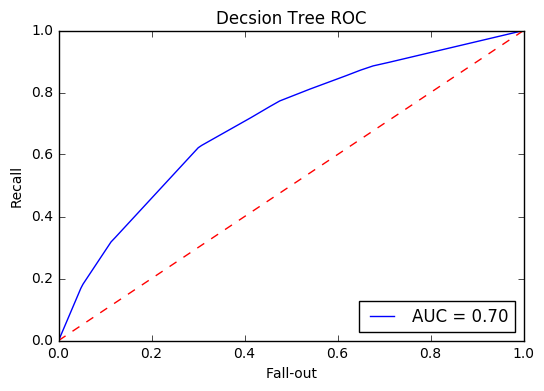

In [40]:
from sklearn.metrics import roc_curve, auc  
predictions = DT.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Decsion Tree ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out')
plt.savefig('Decsion Tree ROC.png',dpi=600)
plt.show()  

##AB(AdaBoost) Classifier

In [41]:
from sklearn.ensemble import AdaBoostClassifier
# 一般来说n_estimators太小，容易欠拟合，n_estimators太大，又容易过拟合，一般选择一个适中的数值。默认是50
#对于同样的训练集拟合效果，较小的νν意味着我们需要更多的弱学习器的迭代次数。通常我们用步长和迭代最大次数一起来决定算法的拟合效果。
#所以这两个参数n_estimators和learning_rate要一起调参。一般来说，可以从一个小一点的νν开始调参，默认是1
Ada= AdaBoostClassifier(n_estimators=200,learning_rate=0.8)
Ada_scores = cross_val_score(Ada, X_train, y_train, cv=10, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (DT_scores.mean(), DT_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(Ada, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

Accuracy: 0.66 (+/- 0.01)
Recall: 0.67 (+/- 0.01)
Precision: 0.67 (+/- 0.01)


###TEST SET

In [42]:
Ada.fit(X_train,y_train)
predict = Ada.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

precision: 67.53%, recall: 65.45%
accuracy: 67.21%


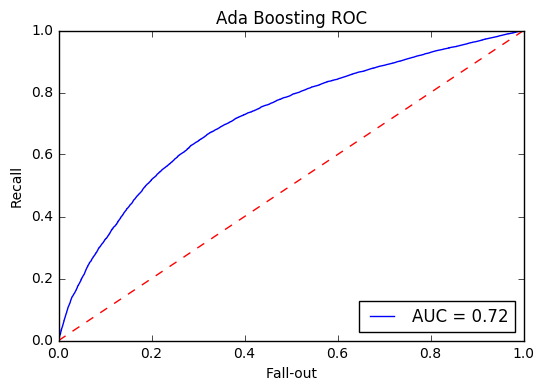

In [43]:
from sklearn.metrics import roc_curve, auc  
predictions = Ada.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('Ada Boosting ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out') 
plt.savefig('Ada Boosting ROC.png',dpi=600)
plt.show() 

##SVM

###Validation

In [ ]:
from sklearn.svm import SVC
svm = SVC(kernel='rbf', C=0.1, gamma=1, probability=True)
svm_scores = cross_val_score(svm, X_train, y_train, cv=3, scoring='accuracy')
print("Accuracy: %0.2f (+/- %0.2f)" % (svm_scores.mean(), svm_scores.std() * 2))

scoring = {'prec_macro': 'precision_macro','rec_micro': make_scorer(recall_score, average='macro')}
all_scores = cross_validate(svm, X_train, y_train, scoring=scoring,cv=10, return_train_score=True)
score = all_scores['test_rec_micro'] 
print("Recall: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))
score = all_scores['test_prec_macro'] 
print("Precision: %0.2f (+/- %0.2f)" % (score.mean(), score.std() * 2))

KeyboardInterrupt: 

###TEST SET

In [ ]:
svm.fit(X_train,y_train)
predict = svm.predict(X_test)
precision = metrics.precision_score(y_test, predict)
recall = metrics.recall_score(y_test, predict)
print ('precision: %.2f%%, recall: %.2f%%' % (100 * precision, 100 * recall))
accuracy = metrics.accuracy_score(y_test, predict)
print ('accuracy: %.2f%%' % (100 * accuracy) )

In [ ]:
from sklearn.metrics import roc_curve, auc  
predictions = LR.predict_proba(X_test)  
false_positive_rate, recall, thresholds = roc_curve(y_test, predictions[:, 1])  
roc_auc = auc(false_positive_rate, recall)  
plt.title('SVM ROC')  
plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)  
plt.legend(loc='lower right')  
plt.plot([0, 1], [0, 1], 'r--')  
plt.xlim([0.0, 1.0])  
plt.ylim([0.0, 1.0])  
plt.ylabel('Recall')  
plt.xlabel('Fall-out') 
plt.savefig('SVM ROC.png',dpi=600)
plt.show()  

## Ridge

In [ ]:
from sklearn import linear_model
LRR = linear_model.Ridge(1.0, fit_intercept=False)
LRR.fit(X_train,y_train)
theta = LRR.coef_

In [ ]:
theta

In [ ]:
MSE = 0
for x,y in zip(X_test,y_test):
    predict = 0
    for i in range(len(theta)):
        predict += x[i]*theta[i]
    MSE += (predict-y)**2
MSE = MSE/float(len(X_test))

In [ ]:
print ('RMSE',MSE**0.5)